In [1]:
import json
import gzip
import pandas as pd
import numpy as np

# BoW and TD-IDF
from sklearn.model_selection import train_test_split
from scipy import sparse as sp_sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

# Confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
# evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

# SVC, USE
import tensorflow_hub as hub
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

import spacy

In [4]:
import spacy
nlp = spacy.load("en_core_web_lg")
doc = nlp("The cat chased the mouse.")
for token in doc:
    print(f"{token.text} -> {token.dep_} -> {token.head.text}")


The -> det -> cat
cat -> nsubj -> chased
chased -> ROOT -> chased
the -> det -> mouse
mouse -> dobj -> chased
. -> punct -> chased


In [2]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


## 1. Data preparatiOn

### 1. data exploration ###

In [3]:
data_list = []
with gzip.open('data/hs-sample-articles.fjson.gz', 'rt', encoding='utf-8') as f:
    for line in f:
        data_list.append(json.loads(line))
        
data = pd.DataFrame(data_list)

print(data.shape) 
data.head()

(2291, 5)


,article_id,training,title,content,source
0,190000,"-Earn,+Fraud,+Mat,-MjInd,+MjCtry,-CreditCh,-Fi...",Brazil prosecutors hit ex-president Lula with ...,Prosecutors on Thursday charged former Brazili...,REUTERS
1,190001,"-Earn,+Fraud,+Mat,-ManCh,+MjCtry,-CreditCh,-Fi...",Trudeau to be questioned by ethics watchdog ov...,Canada’s ethics watchdog will query Justin Tru...,The Guardian
2,190002,"-Earn,-Fraud,+Mat,-ManCh,-MjInd,-MjCtry,-Credi...",Kenya: House to send anti-bribery Bill for pre...,The National Assembly is preparing to forward ...,Daily Nation
3,190003,"-Earn,-Fraud,+Mat,-ManCh,+MjCtry,-CreditCh,-Fi...",EU agrees to extend Russia sanctions until mid...,European Union leaders agreed on Thursday to e...,REUTERS
4,190004,"+Fraud,+Mat,+ManCh,-MjCtry,-CreditCh,+FinDis,-...",Tesco's former commercial boss cleared of frau...,Tesco's former commercial boss Kevin Grace has...,The Telegraph


In [4]:
# target variables: mulit-label text classification 
label_set = set()
for row in data['training']:
    labels = row.split(',')
    for label in labels:
        # extract wo '+' or '-' sign
        label_name = label[1:]   
        label_set.add(label_name)
        
labels = list(label_set)

# convert target: to binary representation (0,1)
for label in labels:
    data[label] = data['training'].apply(lambda x: 1 if f'+{label}' in x else 0)

# merge: title(high), content(high)
data['combined_text'] = data['title'] + ' ' + data['content']

print("Detected set of labels: ", labels)
print("\nCurrent df cols: ", list(data.columns))
print(data.shape)

Detected set of labels:  ['Fines', 'CreditCh', 'Mat', 'ManCh', 'Fraud', 'Earn', 'MjCtry', 'FinDis', 'Other', 'MnA', 'MjInd', 'SevDis']

Current df cols:  ['article_id', 'training', 'title', 'content', 'source', 'Fines', 'CreditCh', 'Mat', 'ManCh', 'Fraud', 'Earn', 'MjCtry', 'FinDis', 'Other', 'MnA', 'MjInd', 'SevDis', 'combined_text']
(2291, 18)


Total class weight:  147.83999999999997 %

 {'Fines': 7.16, 'Earn': 13.18, 'ManCh': 1.83, 'MjCtry': 27.24, 'MnA': 4.93, 'SevDis': 2.71, 'Other': 1.0, 'CreditCh': 0.48, 'Mat': 58.4, 'FinDis': 2.58, 'Fraud': 5.85, 'MjInd': 22.48}


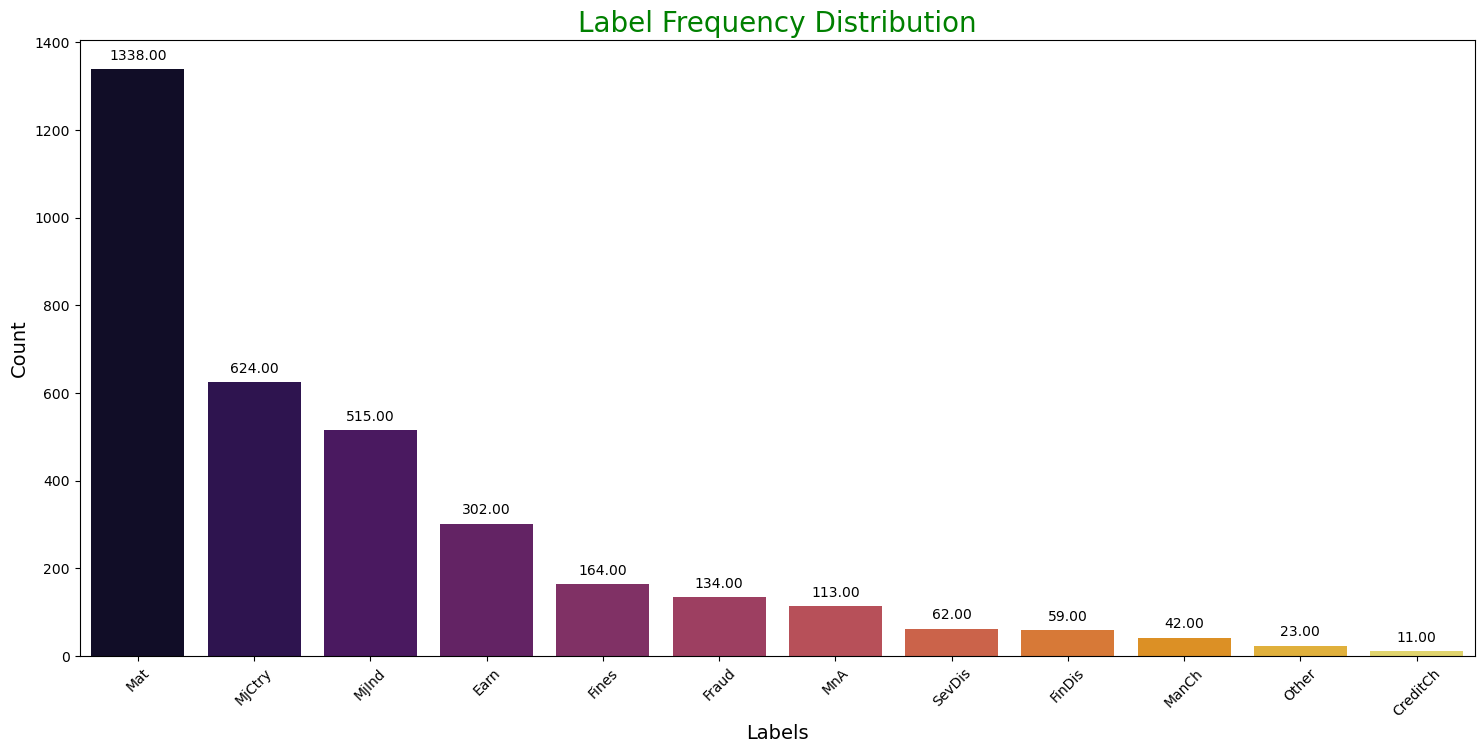

In [7]:
def get_class_weight(data):
    class_weight = {}
    for num,col in enumerate(y_cols):
        if num not in class_weight:
            class_weight[col] = round((data[data[col] == 1][col].sum())/data.shape[0]*100,2)
    return class_weight
    
y_cols = labels 
class_weight = get_class_weight(data)
print('Total class weight: ', sum(class_weight.values()), '%\n\n', class_weight)

#seaborn
label_counts = data[y_cols].sum().sort_values(ascending=False)

#barplot
plt.figure(figsize=[18, 8])
plot = sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette='inferno', legend=False)

# annotate count on top of bars
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.2f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Label Frequency Distribution', fontdict={'fontsize': 20, 'fontweight': 5, 'color': 'Green'})
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

#### Observation made above:
1. can see that the data is highly imbalanced. Imbalanced data refers to classification problems where the classes are not represented equally for e.g., of 58.4% combined_text are classified under the ‘Mat’ label.

#### Handling imbalance on Labels (class_weight='balanced' in Logistic Regression and SVM models later):
1. give higher weight to classes that have fewer positive examples, using this
$$
\text{weight}_i = \frac{\text{total instances}}{\text{number of classes} \times \text{positive instances}_i}
$$

### 2. Split data into train, test, validation

Steps taken here:
1. train-test split: 80/20.

In [5]:
def get_train_test(data):
    X_data = data['combined_text'].values
    y_data = data[list(data.columns[-13:-1])].values
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
    
    # Print the shapes of the train and test sets
    print(
        'X_train shape', X_train.shape,
        '\ny_train shape', y_train.shape,
        '\nX_test shape', X_test.shape,
        '\ny_test shape', y_test.shape,
    )
    return X_train, X_test, y_train, y_test

# Call the function and get the train and test data
X_train, X_test, y_train, y_test = get_train_test(data)

# Uncomment to print the first few lines if needed
# print("\nFirst few lines of X_train:", X_train[:2])
# print("\nFirst few lines of X_test:", X_test[:2])
# print("\nFirst few lines of y_train:", y_train[:2])
# print("\nFirst few lines of y_test:", y_test[:2])

X_train shape (1832,) 
y_train shape (1832, 12) 
X_test shape (459,) 
y_test shape (459, 12)


### 3. Text preprocessing

In [11]:
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
import re
from nltk.stem import PorterStemmer
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hojinwei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/hojinwei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Steps taken here: lexical analysis, stemming and etc.
1. lowercase for standardisation.
2. remove ip address as low impact and also let not 'http...' etc., affect the vocab rank later.
3. replace problematic characters with spaces to avoids merging words unintentionally.
4. removes unwanted symbols except letters, numbers, #, +, _. Reason being sometimes hastag# could be a social media post's tagging.

In [12]:
REPLACE_BY_SPACE_RE = re.compile(r'[/(){}\[\]\|@,;]')  
BAD_SYMBOLS_RE = re.compile(r'[^0-9a-z #+_]')          
STOPWORDS = set(stopwords.words('english'))
REPLACE_IP_ADDRESS = re.compile(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b') 

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.replace('\n', ' ').lower()
    text = REPLACE_IP_ADDRESS.sub('', text)
    text = REPLACE_BY_SPACE_RE.sub(' ',text)
    text = BAD_SYMBOLS_RE.sub('',text)
    text = ' '.join([ps.stem(w) for w in text.split() if w not in STOPWORDS])
    return text

print("\nOriginal Text (~600 chars):", X_train[:1][0][:600])
X_train_bag_tfidf = [text_prepare(x) for x in X_train]


Original Text (~600 chars): Banks and Earnings Power European Shares LONDON — European shares rose in early trade on Wednesday as French lender Credit Agricole led banking stocks higher and earnings provided a boost.

The pan-European STOXX 600 index was up 0.3 percent in early trade with the European banking index the top-gaining sector, up 1.2 percent.

Shares in Credit Agricole jumped 3.2 percent after France's biggest retail bank beat forecasts with a smaller than expected earnings drop in the fourth quarter.

Banking stocks were also helped by hawkish rhetoric from U.S. Federal Reserve Chair Janet Yellen on Tuesday,


In [13]:
# peek first 100 chars of 1st element
print("\nProcessed Text (~600 chars):", X_train_bag_tfidf[:1][0][:600])


Processed Text (~600 chars): bank earn power european share london european share rose earli trade wednesday french lender credit agricol led bank stock higher earn provid boost paneuropean stoxx 600 index 03 percent earli trade european bank index topgain sector 12 percent share credit agricol jump 32 percent franc biggest retail bank beat forecast smaller expect earn drop fourth quarter bank stock also help hawkish rhetor us feder reserv chair janet yellen tuesday said feder reserv like need rais interest rate upcom meet low interest rate put pressur bank margin case europ earn also fuell move higher finnish packag make


## 2. Feature Extraction

### 1. Bag-of-Words (BoW)

In [14]:
# dictionary of all words from train corpus with their counts.
words_counts = {}
for comments in X_train_bag_tfidf:
    for word in comments.split():
        if word not in words_counts:
            words_counts[word] = 1
        words_counts[word] += 1
        
DICT_SIZE = 10000
POPULAR_WORDS = sorted(words_counts, key=words_counts.get, reverse=True)[:DICT_SIZE]
WORDS_TO_INDEX = {key: rank for rank, key in enumerate(POPULAR_WORDS, 0)}
INDEX_TO_WORDS = {index:word for word, index in WORDS_TO_INDEX.items()}
ALL_WORDS = WORDS_TO_INDEX.keys()

In [15]:
def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    for word in text.split(' '):
        if word in words_to_index:
            result_vector[words_to_index[word]] += 1
    return result_vector

X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train_bag_tfidf])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])

print(f"X_train_mybag: {X_train_mybag.shape}, X_test_mybag: {X_test_mybag.shape}")

X_train_mybag: (1832, 10000), X_test_mybag: (459, 10000)


In [49]:
POPULAR_WORDS[:10]

['said',
 'percent',
 'year',
 'us',
 'compani',
 'market',
 'trump',
 'new',
 'one',
 'also']

### 2. TD-IDF

In [16]:
def tfidf_features(X_train, X_test):
    """
        X_train, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5)
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    return X_train_tfidf, X_test_tfidf, tfidf_vectorizer

# apply TF-IDF feature extraction to datasets and verify
X_train_tfidf, X_test_tfidf, tfidf_vectorizer = tfidf_features(X_train_bag_tfidf, X_test)
print(f"X_train: {X_train_tfidf.shape}, X_test: {X_test_tfidf.shape}")

X_train: (1832, 16190), X_test: (459, 16190)


## 3. Model Selection and Training

### 1. Bow + logistic reg
### 2. Tdidf + logistic reg

In [17]:
def train_classifier(X_train, y_train, C, regularisation):
    """
      X_train, y_train — training data
      return: trained classifier
    """
    model = OneVsRestClassifier(LogisticRegression(penalty=regularisation, C=C, max_iter=10000, class_weight='balanced')).fit(X_train, y_train)
    return model

print("Training classifiers with Bag-of-Words and TF-IDF features...")
classifier_mybag = train_classifier(X_train_mybag, y_train, C=4, regularisation='l2')
classifier_tfidf = train_classifier(X_train_tfidf, y_train, C=4, regularisation='l2')

print("Generating predictions for the test set...")
y_test_predicted_labels_mybag = classifier_mybag.predict(X_test_mybag)
y_test_predicted_labels_tfidf = classifier_tfidf.predict(X_test_tfidf)

print("done")

Training classifiers with Bag-of-Words and TF-IDF features...
Generating predictions for the test set...
done


### 3. spaCy (en_core_web_lg)

In [18]:
print("Loading spaCy model with word vectors...")
nlp = spacy.load("en_core_web_lg")

def spacy_word2vec(text_data):
    """
    Convert list of text data into Word2Vec embeddings using spaCy
    text_data: List of sentences or documents
    return: numpy array of word embeddings
    """
    embeddings = []
    for doc in text_data:
        # Use spaCy's built-in vector representation for each document
        doc_vector = nlp(doc).vector
        embeddings.append(doc_vector)
    return np.array(embeddings)

# Prepare embeddings for the train, and test sets
X_train_spacy = spacy_word2vec(X_train)
X_test_spacy = spacy_word2vec(X_test)

# SVM model with RBF kernel
svm_model_rbf_spacy = SVC(kernel='rbf', class_weight='balanced')

# define parameters for GridSearchCV
param_grid = {'estimator__C': [0.1, 1, 10], 'estimator__gamma': ['scale', 'auto']}
grid_search = GridSearchCV(OneVsRestClassifier(svm_model_rbf_spacy), param_grid, cv=3)

print("Training SVM model with RBF kernel using GridSearchCV...")
grid_search.fit(X_train_spacy, y_train)

# store the best found model
best_svm_model_rbf_spacy = grid_search.best_estimator_

# check if best model is fitted
print("Best Parameters found:", grid_search.best_params_)

print("Evaluating on test set (final evaluation)...")
y_test_predicted_spacy_rbf = best_svm_model_rbf_spacy.predict(X_test_spacy)
print(f"X_train: {X_train_spacy.shape}, X_test: {X_test_spacy.shape}")

print("Done.")

Loading spaCy model with word vectors...
Training SVM model with RBF kernel using GridSearchCV...
Best Parameters found: {'estimator__C': 10, 'estimator__gamma': 'auto'}
Evaluating on test set (final evaluation)...
X_train: (1832, 300), X_test: (459, 300)
Done.


### 4. Universal sentence encoder (USE) + Support vectOr machine (SVM)
1. takes X_train instead of the manual feature extraction done for BoW, Tdidf, so as to retain word's meaning.

In [19]:
print("Loading Universal Sentence Encoder (USE) model...")
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# embed text data using USE
def embed_text(text_data):
    return use_model(text_data).numpy()

X_train_use = embed_text(X_train)
X_test_use = embed_text(X_test)

# SVM model with RBF kernel
svm_rbf = SVC(kernel='rbf', class_weight='balanced')

# define parameters for GridSearchCV
param_grid = {'estimator__C': [0.1, 1, 10], 'estimator__gamma': ['scale', 'auto']}
grid_search = GridSearchCV(OneVsRestClassifier(svm_rbf), param_grid, cv=3)

print("Training SVM model with RBF kernel using GridSearchCV...")
grid_search.fit(X_train_use, y_train)

# store the best found model
best_svm_model_rbf = grid_search.best_estimator_

# check if best model is fitted
print("Best Parameters found:", grid_search.best_params_)

print("Evaluating on test set (final evaluation)...")
y_test_predicted_use_rbf = best_svm_model_rbf.predict(X_test_use)

print(f"X_train: {X_train_use.shape}, X_test: {X_test_use.shape}")
print("Done.")

Loading Universal Sentence Encoder (USE) model...
Training SVM model with RBF kernel using GridSearchCV...
Best Parameters found: {'estimator__C': 10, 'estimator__gamma': 'scale'}
Evaluating on test set (final evaluation)...
X_train: (1832, 512), X_test: (459, 512)
Done.


### 5. BERT + BiLSTM

#### 1. Preparing BERT Embeddings

In [13]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [86]:
from transformers import BertTokenizer, BertModel, DistilBertTokenizer, DistilBertModel
import torch

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

#Load pre-trained model
bert_model = BertModel.from_pretrained('bert-base-uncased')
#bert_model = DistilBertModel.from_pretrained('distilbert-base-cased')
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

#### 2. Once the model is loaded, we can tokenize our input text and obtain the embeddings:

In [87]:
#input_text = "Your input text here"
#inputs = tokenizer(input_text, return_tensors='pt')
#with torch.no_grad():
#    outputs = model(**inputs)
#    embeddings = outputs.last_hidden_state # to be used as input to LSTM later

#hyperparams
max_length = 128

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, max_length=max_length):
        self.texts = texts
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        
        # Tokenize the text using BERT tokenizer
        encoding = tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].squeeze(0)  # Remove the batch dimension
        attention_mask = encoding['attention_mask'].squeeze(0)
        
        return input_ids, attention_mask, label

# Prepare datasets for training and testing
train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

# hyperparams
batch_size = 16

# DataLoaders to handle batches of data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

The embeddings tensor now contains the BERT embeddings for the input text, which can be used as input to the LSTM.

#### 3. Building the BiLSTM Model

In [88]:
#class LSTMModel(torch.nn.Module):
#    def __init__(self, embedding_dim, hidden_dim, output_dim):
#        super(LSTMModel, self).__init__()
#        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
#        self.fc = torch.nn.Linear(hidden_dim, output_dim)

#    def forward(self, x):
#        lstm_out, _ = self.lstm(x)
#        out = self.fc(lstm_out[:, -1, :])  # Get the last time step output
#        return out

# hyperparams
bidirectional_flag = True
num_layers_lstm = 1
drop_out = 0.2

class LSTMModel(torch.nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, num_layers=num_layers_lstm, bidirectional=bidirectional_flag, dropout=drop_out):
        super(LSTMModel, self).__init__()
        self.bert = bert_model
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim, num_layers, bidirectional=bidirectional, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            bert_embeddings = bert_outputs.last_hidden_state  # (batch_size, seq_len, embedding_dim)
        
        lstm_out, _ = self.lstm(bert_embeddings)  # (batch_size, seq_len, hidden_dim)
        lstm_out = lstm_out[:, -1, :]  # Last hidden state
        output = self.fc(lstm_out)
        return self.sigmoid(output)

print(y_train.shape)

(1832, 12)


In this model, the LSTM processes the sequence of BERT embeddings, and the final output is passed through a fully connected layer to produce the desired output.

#### 4. Training the Model

In [24]:
# Hyperparameters
#embedding_dim = 768  # BERT output size
#hidden_dim = 128
#output_dim = 1  # For binary classification
#num_epochs = 5

#model = LSTMModel(embedding_dim, hidden_dim, output_dim)
#criterion = torch.nn.BCEWithLogitsLoss() # use BCE because got 12 output labels aka binary cross entropy
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Example labels (for binary classification, you can replace it with actual labels)
#labels = torch.tensor([1.0])  # Example label for binary classification
# Reshape the labels to match the model output size [1, 1]
#labels = labels.unsqueeze(1)
                      
# Training loop
#for epoch in range(num_epochs):
#    model.train()
#    optimizer.zero_grad()
#    outputs = model(embeddings) # Forward pass
#    loss = criterion(outputs, labels)
#    loss.backward()
#    optimizer.step() # Update model parameters

#    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/5, Loss: 0.6617134213447571
Epoch 2/5, Loss: 0.3501274585723877
Epoch 3/5, Loss: 0.1853526532649994
Epoch 4/5, Loss: 0.10620231926441193
Epoch 5/5, Loss: 0.06696159392595291


In [ ]:
# hyperparams
embedding_dim = 768  # BERT output size
hidden_dim = 128
output_dim = y_train.shape[1]  # For multi-label classification (12 labels)
num_epochs = 200 # can put more epoch to hit lower loss, if have higher computational power for faster
learning_rate = 0.01

model = LSTMModel(embedding_dim, hidden_dim, output_dim).to('mps')

criterion = torch.nn.BCEWithLogitsLoss() # use BCE because got 12 output labels aka binary cross entropy
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = model.to(device)

from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()  # For handling scaled gradients during AMP

print("running epoch for BiLSTM...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for input_ids, attention_mask, labels in train_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
            
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

running epoch for BiLSTM...
Epoch 1/200, Loss: 0.6939765261567157
Epoch 2/200, Loss: 0.6863053197446076
Epoch 3/200, Loss: 0.6851662454397782


In [54]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for input_ids, attention_mask, labels in test_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            
            outputs = model(input_ids, attention_mask)
            preds = (outputs > 0.5).float()  # Convert to binary predictions
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    return all_preds, all_labels

In [ ]:
all_preds, all_labels = evaluate_model(model, test_loader)

# Flatten the lists to compute metrics for the entire dataset
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

def print_evaluation_scores(y_test, predicted):
    print(f"Accuracy: {accuracy_score(y_test, predicted):.4f}")
    print(f"F1-score macro: {f1_score(y_test, predicted, average='macro'):.4f}")
    print(f"F1-score micro: {f1_score(y_test, predicted, average='micro'):.4f}")
    print(f"F1-score weighted: {f1_score(y_test, predicted, average='weighted'):.4f}")
    print(f"Precision macro: {average_precision_score(y_test, predicted, average='macro'):.4f}")
    print(f"Precision micro: {average_precision_score(y_test, predicted, average='micro'):.4f}")
    print(f"Precision weighted: {average_precision_score(y_test, predicted, average='weighted'):.4f}")

print('\nBERT + BiLSTM (Test Set)\n')
print_evaluation_scores(all_labels, all_preds)

## Prediction and EvaluatiOn

#### Presenting to business manager:
Accuracy: Tells us how often the model is right overall, but it doesn’t always show the full picture in the case of one tagging(category) is much more common than others.

F1-score macro: Looks at each category equally and checks how well the model balances being right about the "positive" predictions for each one.

F1-score micro: Focuses more on categories that appear a lot, showing how well the model performs for the most frequent items.

F1-score weighted: Combines both approaches, giving a balanced score that takes into account how often each category shows up, giving us a clearer overall performance.

Precision macro: Measures how often the model’s positive guesses are correct, treating all categories equally, even the less frequent ones.

Precision micro: Concentrates on the overall quality of the model’s positive guesses, paying more attention to common categories.

Precision weighted: Combines the model’s precision across all categories, while also accounting for how often each one appears, providing a more balanced view.

In [20]:
def print_evaluation_scores(y_test, predicted):
    print(f"Accuracy: {accuracy_score(y_test, predicted):.4f}")
    print(f"F1-score macro: {f1_score(y_test, predicted, average='macro'):.4f}")
    print(f"F1-score micro: {f1_score(y_test, predicted, average='micro'):.4f}")
    print(f"F1-score weighted: {f1_score(y_test, predicted, average='weighted'):.4f}")
    print(f"Precision macro: {average_precision_score(y_test, predicted, average='macro'):.4f}")
    print(f"Precision micro: {average_precision_score(y_test, predicted, average='micro'):.4f}")
    print(f"Precision weighted: {average_precision_score(y_test, predicted, average='weighted'):.4f}")

print('Evaluating models...')
print('BoW + Logistic Regression (Test Set)\n')
print_evaluation_scores(y_test, y_test_predicted_labels_mybag)

print('\nTF-IDF + Logistic Regression (Test Set)\n')
print_evaluation_scores(y_test, y_test_predicted_labels_tfidf)

print('\nSpaCy + SVM (Test Set)\n')
print_evaluation_scores(y_test, y_test_predicted_spacy_rbf)

print('\nUSE + SVM (Test Set)\n')
print_evaluation_scores(y_test, y_test_predicted_use_rbf)

print("\nProcess completed.")

Evaluating models...
BoW + Logistic Regression (Test Set)

Accuracy: 0.3682
F1-score macro: 0.1651
F1-score micro: 0.3534
F1-score weighted: 0.3200
Precision macro: 0.1755
Precision micro: 0.2632
Precision weighted: 0.4231

TF-IDF + Logistic Regression (Test Set)

Accuracy: 0.4815
F1-score macro: 0.4837
F1-score micro: 0.6522
F1-score weighted: 0.6377
Precision macro: 0.3637
Precision micro: 0.5026
Precision weighted: 0.5812

SpaCy + SVM (Test Set)

Accuracy: 0.4139
F1-score macro: 0.5781
F1-score micro: 0.7018
F1-score weighted: 0.7164
Precision macro: 0.4031
Precision micro: 0.5255
Precision weighted: 0.6009

USE + SVM (Test Set)

Accuracy: 0.6122
F1-score macro: 0.6570
F1-score micro: 0.7843
F1-score weighted: 0.7790
Precision macro: 0.5007
Precision micro: 0.6460
Precision weighted: 0.6803

Process completed.


## Reasoning based on intuition and observation on Methods (Feature Extraction + MOdels):
### Comparing BoW vs TF-IDF:
1. Reason for + Model: BoW and TF-IDF result in linearly separable data, which Logistic Regression can classify effectively.
2. BoW vs Tfidf (similar): Both BoW and Tfidf have high dimensionality and lack word embeddings, meaning no understanding of words.
3. BoW vs Tfidf (difference): Tfidf reduces weights amoung common words and increases the importance of words that distinguish documents, as reflected in improvements in metrics like f1-score and precision (further refer below for comparison table).
4. Limitations: As noted in point 2. This leads me to word/sentence embedding next: SpaCy's (_lg's) vs USE.

### Comparing SpaCy aka (_lg's) vs USE:
1. Reason for + Model: SpaCy and USE result in non-linear data due to word relationships, which SVM can classify effectively.
2. Reason for usage: SpaCy has POS tagging, dependency parsing, and NER, whereas USE focuses on sentence-level embeddings and semantic similarity tasks.
3. SpaCy vs USE (difference): SpaCy word-level relationships vs USE sentence-level relationships. For e.g., USE effectively handles the difference between "I went to a bank to withdraw money" and "I sat by the river bank," where SpaCy focuses on parsing but may not resolve meaning as effectively.
4. SpaCy vs USE (similar): Both use fixed-size representations, meaning that once we get the word or sentence embeddings, they don't adapt or fine-tune based on the article's data. This brings me to the next methods for dynamic contextual embeddings, that can adapt based on the input text: BERT + BiLSTM.

### BERT + BiLSTM:
1. Reason + model: BERT alone provides powerful representations but does not capture sequential dependencies the same way that LSTM can. Combining both retains rich contextualized information and to model dependencies across time steps. E.g., useful for order of words or phrases in the article matters.
2. Reason foor usage: LSTM adds sequential dependecy learning BERT's contextual embeddings. It capture past and future context and the BiLSTM also processes the sequence in both left and right context of each word.
3. UniLSTM vs BiLSTM: left to right vs both directions.
4. Limitations: 1) training time long 2) Memory consumption high

In [78]:
feature_data = {
    "Feature": ["Context Understanding", "Dimensionality", "Reason for Use"],
    "BoW": [
        "No context (words treated independently)", 
        "High-dimensional, sparse vectors", 
        "Obsolete"
    ],
    "TF-IDF": [
        "No context (words treated independently)", 
        "High-dimensional, slightly better with rare words", 
        "Choose TF-IDF if embeddings for the required language are not available."
    ],
    "spaCy (_lg)": [
        "Handles word context but limited to individual words", 
        "Fixed-length low-dimensional, dense vectors", 
        "Choose spaCy for word-level understanding task."
    ],
    "USE": [
        "Captures sentence-level context", 
        "Fixed-length low-dimensional, dense vectors", 
        "Choose USE for sentence-level understanding task."
    ],
    "BERT": [
        "Captures both word-level and sentence-level context dynamically", 
        "Low-dimensional, dynamic contextual embeddings", 
        "Choose BERT for tasks requiring subtle contextual understanding at both word and sentence level.",
    ],
}
feature_df = pd.DataFrame(feature_data)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
feature_df = feature_df.style.set_properties(**{'text-align': 'left'})
feature_df


,Feature,BoW,TF-IDF,spaCy (_lg),USE,BERT
0,Context Understanding,No context (words treated independently),No context (words treated independently),Handles word context but limited to individual words,Captures sentence-level context,Captures both word-level and sentence-level context dynamically
1,Dimensionality,"High-dimensional, sparse vectors","High-dimensional, slightly better with rare words","Fixed-length low-dimensional, dense vectors","Fixed-length low-dimensional, dense vectors","Low-dimensional, dynamic contextual embeddings"
2,Reason for Use,Obsolete,Choose TF-IDF if embeddings for the required language are not available.,Choose spaCy for word-level understanding task.,Choose USE for sentence-level understanding task.,Choose BERT for tasks requiring subtle contextual understanding at both word and sentence level.
